# Homework 4: Regression with Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information Health Engineering, 2019-2020*

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

The aim of this homework is to solve a real data problem using the Gaussian Process implementation of GPy. The documentation of GPy is avaialable from the [SheffieldML github page](https://github.com/SheffieldML/GPy) or from [this page](http://gpy.readthedocs.org/en/latest/). 

The problem is the prediction of both the heating load (HL) and cooling load (CL) of residential buildings. We consider eight input variables for each building: relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area, glazing area distribution.

In this [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) you can find a detailed description of the problem and a solution based on linear regression [(iteratively reweighted least squares (IRLS) algorithm)](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=10&ved=2ahUKEwjZuoLY2OjgAhUs3uAKHUZ7BVcQFjAJegQIAhAC&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F9b92%2F18e7233f4d0b491e1582c893c9a099470a73.pdf&usg=AOvVaw3YDwqZh1xyF626VqfnCM2k) and random forests. Using GPs, our goal is not only estimate accurately both HL and CL, but also get a measure of uncertainty in our predictions.

The data set can be downloaded from the [UCI repository](https://archive.ics.uci.edu/ml/datasets/Energy+efficiency#).

### 1. Loading and preparing the data

* Download the dataset
* Divide at random the dataset into train (80%) and test (20%) datasets 
* Normalize data if needed

In [0]:
from google.colab import files
import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')


In [127]:
uploaded = files.upload()

# lo cargamos en un dataframe de pandas
df = pd.read_csv(io.BytesIO(uploaded['HW4_data_csv.csv']))

# borramos las dos ultimas columnas
df.__delitem__('Unnamed: 10')
df.__delitem__('Unnamed: 11')
print(df)

"""
Specifically:
X1 Relative Compactness
X2 Surface Area
X3 Wall Area
X4 Roof Area
X5 Overall Height
X6 Orientation
X7 Glazing Area
X8 Glazing Area Distribution
y1 Heating Load
y2 Cooling Load

"""


Saving HW4_data_csv.csv to HW4_data_csv (8).csv
       X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28
..    ...    ...    ...     ...  ...  ..  ...  ..    ...    ...
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  17.88  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.54  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  16.44  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.48  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.64  16.03

[768 rows x 10 columns]


In [128]:
# convertimos a array de numpy
data = pd.DataFrame(df).to_numpy()
print(f"\n Tamanio datos: \n{data.shape}")
#print(data)


 Tamanio datos: 
(768, 10)


In [129]:
# dividimos el dataset

X = data[:,0:8]
Y = data[:,8:10]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
print(f"\n Tamanio datos test: \n{y_test.shape}")

# Normalizar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(f"\n Transformador de datos con media 0 y varianza 1: \n{scaler}")

print(f"\n Datos normalizados media: \n {X_train.mean(axis=0)}")
print(f"\n Datos normalizados varianza: \n {X_train.std(axis=0)}")


 Tamanio datos test: 
(154, 2)

 Transformador de datos con media 0 y varianza 1: 
StandardScaler(copy=True, with_mean=True, with_std=True)

 Datos normalizados media: 
 [-2.58407121e-15 -1.71415542e-16 -6.16864419e-16  2.82980299e-16
 -5.06290630e-18 -1.92390439e-16 -3.08837284e-16 -5.27988800e-17]

 Datos normalizados varianza: 
 [1. 1. 1. 1. 1. 1. 1. 1.]


In [0]:
# dividimos la variable objetivo en dos
y_test_HL = Y_test[:,0]
y_test_CL = Y_test[:,1]


### 2. Setting and optimizing the model

You will train two independent GPs, one to estimate HL and one to estimate CL. For each of the two GPs ...

**On the training data set:**

a) Build a GP regression model based on a RBF kernel with ARD, in which each input dimension is weighted with a different lengthscale, plus some constant noise term. 

b) Fit the covariance function parameters and noise variance. 

c) According to the ARD parameters found, what variables are more important for the regression? Compare it to Table 8 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X) 

**On the test data set:**

d) Compute the test mean absolute error error and the test mean square error (MSE)  using the GP posterior mean and the optimized hyperparameters. Compare your results with Tables 6 and 7 in the [paper](https://www.sciencedirect.com/science/article/pii/S037877881200151X).


2) Try to improve your results by using a more complicated kernel, in which you combine various covariance functions. In this [link](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) you can see how to define different kernels and combine  them. Comments the results. 



In [71]:
# You can also install GPy using the following command (Works on Windows!)

!pip install GPy 

     |████████████████████████████████| 1.0MB 2.9MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for GPy: filename=GPy-1.9.9-cp36-cp36m-linux_x86_64.whl size=2633994 sha256=669d34aa32eec44bdf6a7925d0d98b1794f6c9de6c2450a0f23cbc27b41f5abc
  Stored in directory: /root/.cache/pip/wheels/5d/36/66/2b58860c84c9f2b51615da66bfd6feeddbc4e04d887ff96dfa
  Created wheel for paramz: filename=paramz-0.9.5-cp36-none-any.whl size=102551 sha256=e839873f1a0bab787617c0ae65c7c4dea857343e0aa76a428c2904548ce381a5
  Stored in directory: /root/.cache/pip/wheels/c8/4a/0e/6e0dc85541825f991c431619e25b870d4b812c911214690cf8
Successfully built GPy paramz


In [0]:
import GPy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

In [0]:
# seleccionar una serie de puntos aleatorios de X
n = 20  
index = np.random.choice(X_train.shape[0], n, replace=False) 

x_random = X[index]
y_random = Y[index]


In [0]:
# selecionandoo puntos aleatorios de una columna

columna = 5
X_new=X[:,columna]
#print("\n Tamanio X_new: \n",X_new.shape)
Y_new_HL=Y[:,0]
##print("\n Tamanio Y_new_HL: \n",Y_new_HL.shape)
Y_new_CL=Y[:,1]
##print("\n Tamanio Y_new_CL: \n",Y_new_CL.shape)

#print("\n X: \n",X)
#print("\n Y_new_HL: \n",Y_new_HL)
#print("\n Y_new_CL: \n",Y_new_CL)

X_new = X_new[index]
Y_new_HL=Y_new_HL[index]
Y_new_CL=Y_new_CL[index]

Text(0, 0.5, '$Y$')

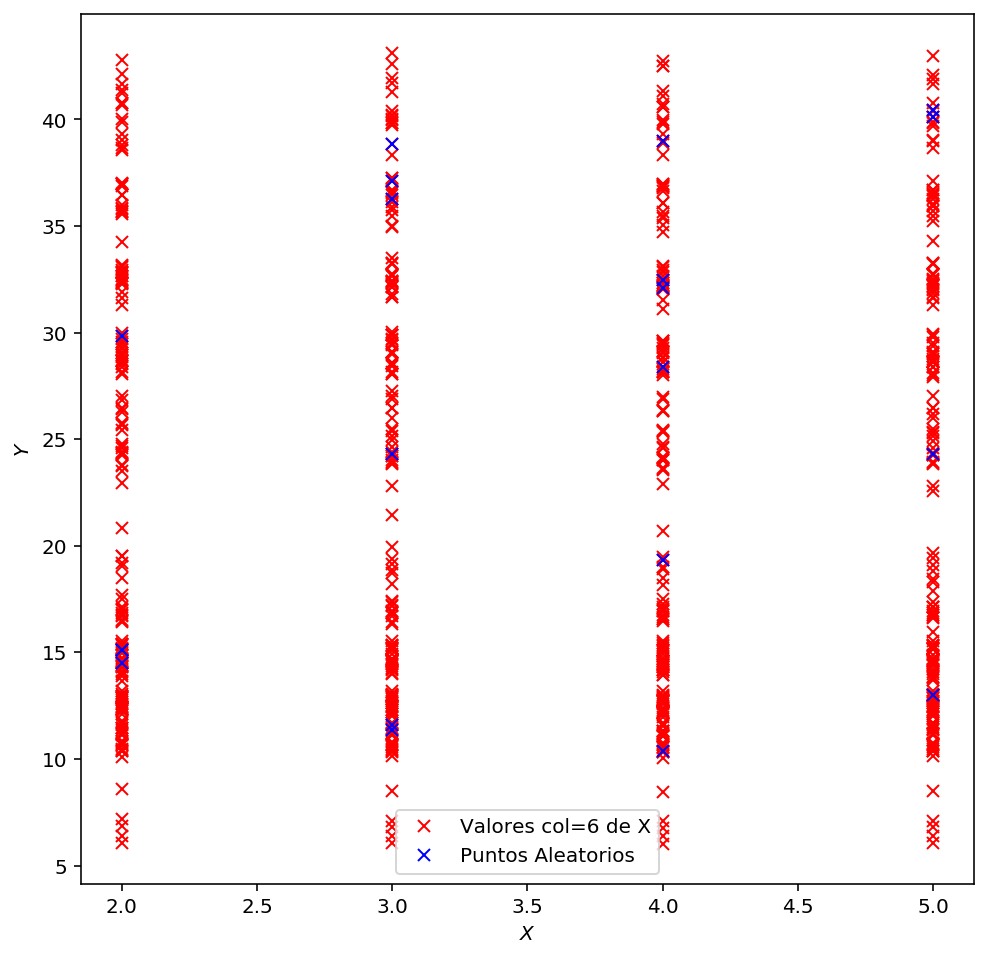

In [136]:
#graficamos los puntos aleatorios
plt.figure()
plt.plot(X[:,columna],Y[:,0],'rx')
plt.plot(X_new,Y_new_HL,'bx',ms=6)
plt.legend(['Valores col='+str(columna+1)+' de X','Puntos Aleatorios'])
plt.xlabel('$X$')
plt.ylabel('$Y$')
#plt.xlim([-1,1])

In [0]:
#Your code here
npoints = 20
X_points = np.linspace(-1,1,npoints)[:,None]
Y_points = -np.cos(2*np.pi*X)* + np.sin(4*np.pi*X) + np.random.randn(npoints,1) * np.sqrt(0.01)

X_true = np.linspace(-5,5,1000)[:,None]
Y_true = -np.cos(2*np.pi*X_true)* + np.sin(4*np.pi*X_true)

plt.figure()
plt.plot(X_true,Y_true,'r')
plt.plot(X,Y,'bx',ms=6)
plt.legend(['True Function','Noisy training points'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([-1,1])

### Sparse GP implementation 

Try to implement an sparse version of the GP regressor, optimized to find a set of **inducing points** that the GP relies on to do the prediction. Measure the test error prediction for 20, 40, and 100 inducing points. 

In [0]:
#Your code here